# Preprocessing step

In [1]:
import pandas as pd
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer

trump = pd.read_csv('/content/trump.csv')
metadata = pd.read_csv('/content/trumpYouTubeChannel2023 2.csv')

In [ ]:
trump.head()

In [2]:
metadata_sorted = metadata.sort_values(by = 'ViewCount', ascending = False)

Drop columns that are not useful

In [3]:
metadata_sorted = metadata_sorted.drop(['Kind', 'ETag', 'ChannelId', 'DefaultThumbnailUrl','MediumThumbnailUrl','HighThumbnailUrl','StandardThumbnailUrl','MaxResThumbnailUrl' ], axis =1)

In [ ]:
metadata_sorted.head()

Insert the video topic. Topic are manually obtained by watching videos

In [4]:
metadata_sorted['Topic'] = ['campaign','campaign', 'addressing','addressing', 'drugs', 'maui', 'campaign','education','campaign','energy','others','campaign','others','campaign','drugs','addressing','campaign','campaign','economy','human traffic','campaign','education','campaign','drugs','others','military','addressing','immigration','economy','economy','campaign','economy','drugs','campaign','military','economy','health','others','addressing','auto industry','military']

In [6]:
print(metadata_sorted['Topic'].unique())

['campaign' 'addressing' 'drugs' 'maui' 'education' 'energy' 'others'
 'economy' 'human traffic' 'military' 'immigration' 'health'
 'auto industry']


Merge the preprocessed data with the metadata

In [5]:
merged_trump = pd.merge(trump,metadata_sorted, on = 'Video ID', how = 'inner')

In [ ]:
merged_trump

# Sentiment analysis using VADER


In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def rule_based_sentiment_analysis(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)

    # Determine sentiment based on compound score
    if sentiment_scores['compound'] >= 0.05:
        return 1
    elif sentiment_scores['compound'] > -0.05 and sentiment_scores['compound'] < 0.05:
        return 0
    else:
      return -1

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


This function will return all VADER scores

In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def rule_based_sentiment_analysis_scores(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
X = []
for value in merged_trump['cleaned']:
  X.append(rule_based_sentiment_analysis(value))


In [10]:
Y = []
for value in merged_trump['cleaned']:
  Y.append(rule_based_sentiment_analysis_scores(value))

In [ ]:
merged_trump['vader_label'] = X

merged_trump

In [ ]:
new_data_df = pd.DataFrame(Y)

# Concatenate the existing DataFrame with the new DataFrame along columns (axis=1)
merged_trump = pd.concat([merged_trump, new_data_df], axis=1)

# Display the result DataFrame
print(merged_trump)

This code set the threshold for polarity

In [ ]:
# Apply the modified conditions
merged_trump['polarity'] = np.where((merged_trump['vader_label'] == 1) & (merged_trump['pos'] > 0.5), 2,  # If vader_label is 1 and pos > 0.5, label 2
                              np.where((merged_trump['vader_label'] == 1) & (merged_trump['pos'] < 0.5), 1,  # If vader_label is 1 and pos < 0.5, label 1
                                       np.where((merged_trump['vader_label'] == -1) & (merged_trump['neg'] < -0.5), -2,  # If vader_label is -1 and neg < -0.5, label -2
                                                np.where((merged_trump['vader_label'] == -1) & (merged_trump['neg'] > -0.5), -1,  # If vader_label is -1 and neg > -0.5, label -1
                                                         np.where(merged_trump['vader_label'] == 0, 0,-1)))))  # If vader_label is 0, label 0, otherwise -1


print(merged_trump)


In [ ]:
polarity_counts = merged_trump.groupby(['Topic', 'polarity']).size().reset_index(name='count')
print(polarity_counts)

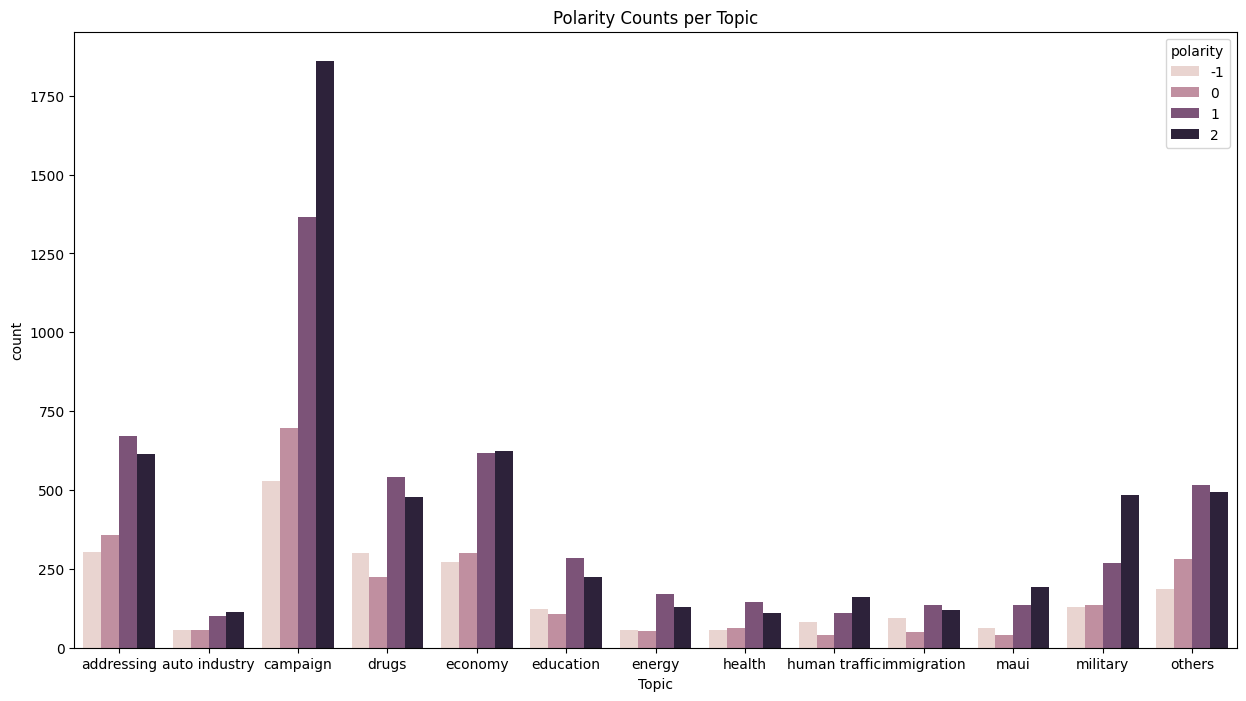

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
# Assuming polarity_counts DataFrame from the previous code snippet
sns.barplot(x='Topic', y='count', hue='polarity', data=polarity_counts)
plt.title('Polarity Counts per Topic')
plt.show()

In [16]:
count_trump_senti = merged_trump.groupby('Topic')['vader_label'].value_counts().unstack(fill_value=0).sort_values(by=1)

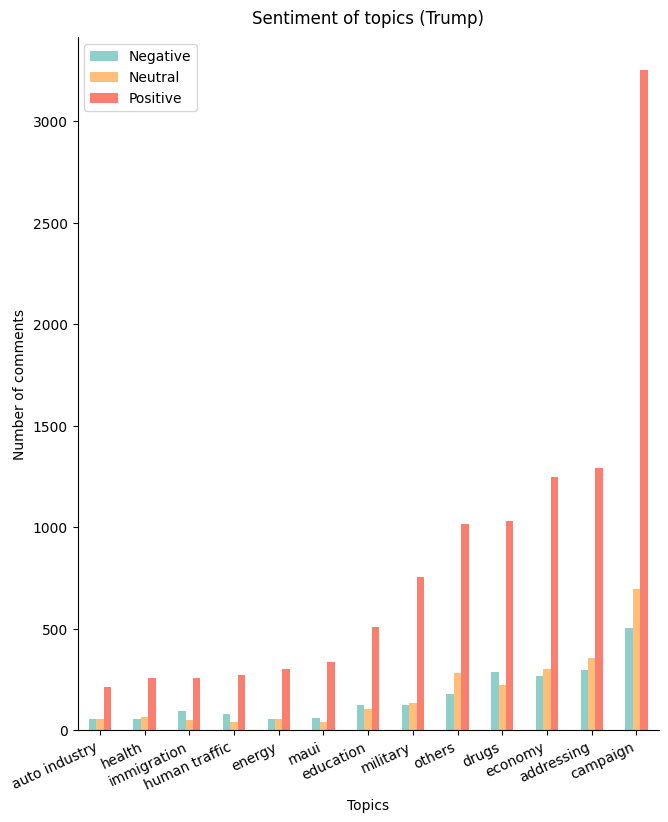

In [17]:
colors = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2', '#BEB8DC', '#E7DAD2']
fig, ax = plt.subplots(figsize=(7.5, 9))
count_trump_senti.plot(kind='bar', color=colors, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Topics")
ax.set_ylabel("Number of comments")
ax.set_title("Sentiment of topics (Trump)", pad=10)
ax.legend(['Negative', 'Neutral', 'Positive'])
plt.xticks(rotation=25, ha='right')
plt.savefig('senti_topics_trump.png')

In [18]:
merged_trump['date'] = pd.to_datetime(merged_trump['Comment Published At'], format='%Y-%m-%dT%H:%M:%SZ').dt.strftime('%Y-%m-%d')

# Now 'date' column contains the date in the 'YYYY-MM-DD' format
print(merged_trump['date'])

0        2023-08-15
1        2023-08-17
2        2023-08-16
3        2023-08-17
4        2023-08-15
            ...    
15306    2023-06-19
15307    2023-06-15
15308    2023-06-11
15309    2023-06-10
15310    2023-06-15
Name: date, Length: 15311, dtype: object


In [19]:
merged_trump['date'] = pd.to_datetime(merged_trump['date'])

In [20]:
label_counts_per_month = merged_trump.groupby([merged_trump['date'].dt.to_period('M'), 'vader_label']).size().unstack(fill_value=0)

# Now 'label_counts_per_month' is a DataFrame containing the counts of each label per month
print(label_counts_per_month)

vader_label   -1    0     1
date                       
2023-03       14   15   123
2023-04      290  305  1534
2023-05      419  548  2463
2023-06      576  604  2605
2023-07      289  259  1234
2023-08      397  458  1636
2023-09       92  104   457
2023-10       32   28   127
2023-11       20   20   106
2023-12       44   59   412
2024-01        3    4    34


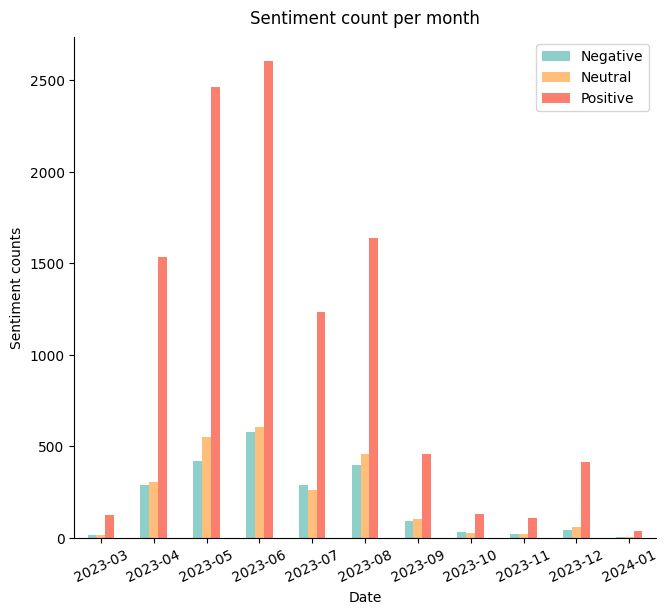

In [21]:
colors = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2', '#BEB8DC', '#E7DAD2']
fig, ax = plt.subplots(figsize=(7.5, 6.5))
label_counts_per_month.plot(kind='bar', ax=ax, color= colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment counts")
ax.set_title("Sentiment count per month", pad=10)
ax.legend(['Negative','Neutral','Positive'])
plt.xticks(rotation=25)

plt.savefig('Sentiment count per month (Trump).png')

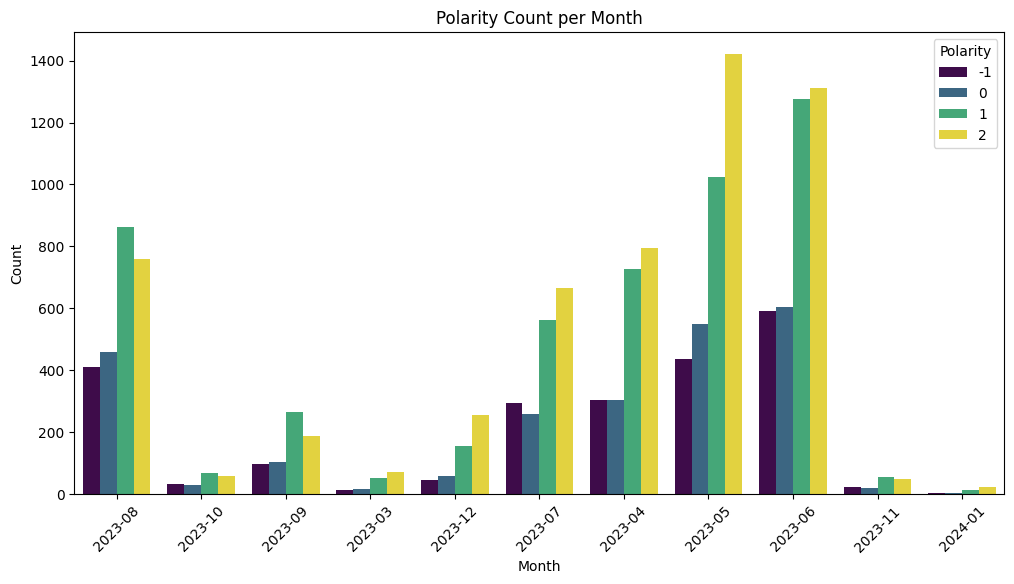

In [22]:
plt.figure(figsize=(12, 6))
sns.countplot(x= merged_trump['date'].dt.to_period('M').sort_values(), hue='polarity', data=merged_trump, palette='viridis')
plt.title('Polarity Count per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Polarity', loc='upper right')
plt.show()